# Customer Segmentation Report

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE

In [2]:
sns.set_style('whitegrid')

# 1. Loading the datasets

In [3]:
%%time
customers = pd.read_csv('./data/AzdiasCustomersPreprocessed.csv', low_memory=False)
population = pd.read_csv('./data/AzdiasPopulationPreprocessed.csv', low_memory=False)

Wall time: 1min 18s


# 2. Dimensionality reduction with PCA

First of all, we will run PCA with a number of components equal to the number of columns to see the marginal explained variance of each component.

In [8]:
population_pca = PCA(n_components=population.shape[1], random_state=77)
pca = population_pca.fit(population)

## 2.1. Choosing the number of PCs

In [9]:
cumulative_variance_ratio = population_pca.explained_variance_ratio_.cumsum()

The number of principal components required to obtain at least 80% explained variance:

In [10]:
no_of_components_08 = population.shape[1] - cumulative_variance_ratio[cumulative_variance_ratio > 0.8].shape[0] + 1
print(no_of_components_08)

127


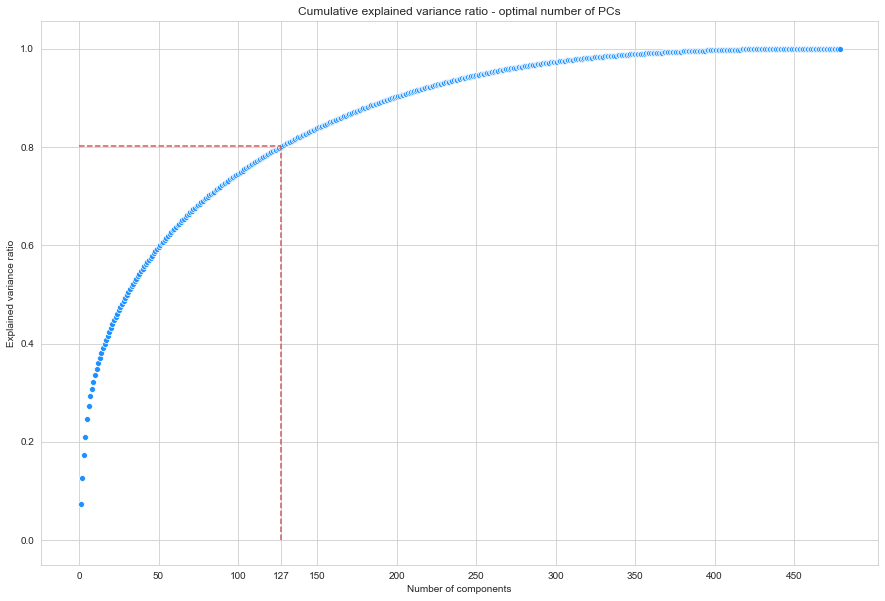

In [11]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=np.arange(1, population.shape[1]+1), y=cumulative_variance_ratio, 
                color='dodgerblue')
plt.hlines(y=cumulative_variance_ratio[no_of_components_08], xmin=0, xmax=no_of_components_08, color='indianred', linestyles='--', zorder=1)
plt.vlines(x=no_of_components_08, ymin=0, ymax=cumulative_variance_ratio[no_of_components_08], color='indianred', linestyles='--', zorder=2)
plt.xticks([i for i in range(0, population.shape[1], 50)] + [no_of_components_08])
plt.title('Cumulative explained variance ratio - optimal number of PCs')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.show()

## 2.2. Fitting the PCs

In [12]:
population_pca = PCA(n_components=no_of_components_08, random_state=77)
pca = population_pca.fit(population)

## 2.3. Inspecting the PCs

In [13]:
print('The top 6 principal components explain about {}% of the variance'
      .format(np.round(cumulative_variance_ratio[5]*100, decimals=3)))

The top 6 principal components explain about 27.397% of the variance


Let's take a look at the top 6 principal components and their top 10 variables by weight.

In [14]:
for i in range(1, 7, 1):
    tmp = pd.Series(pca.components_[i-1], index=population.columns.values)
    top10index = tmp.abs().sort_values(ascending=False)[0:10].index.values
    globals()['pc'+str(i)] = tmp[top10index]

The cell below plots a grid of bar charts, which have a gradient coloring similar to a heatmap. As such, negative feature loadings on the PCs are blue, while positive feature loadings are red. Also, the higher the weight value, the more intense the color is.

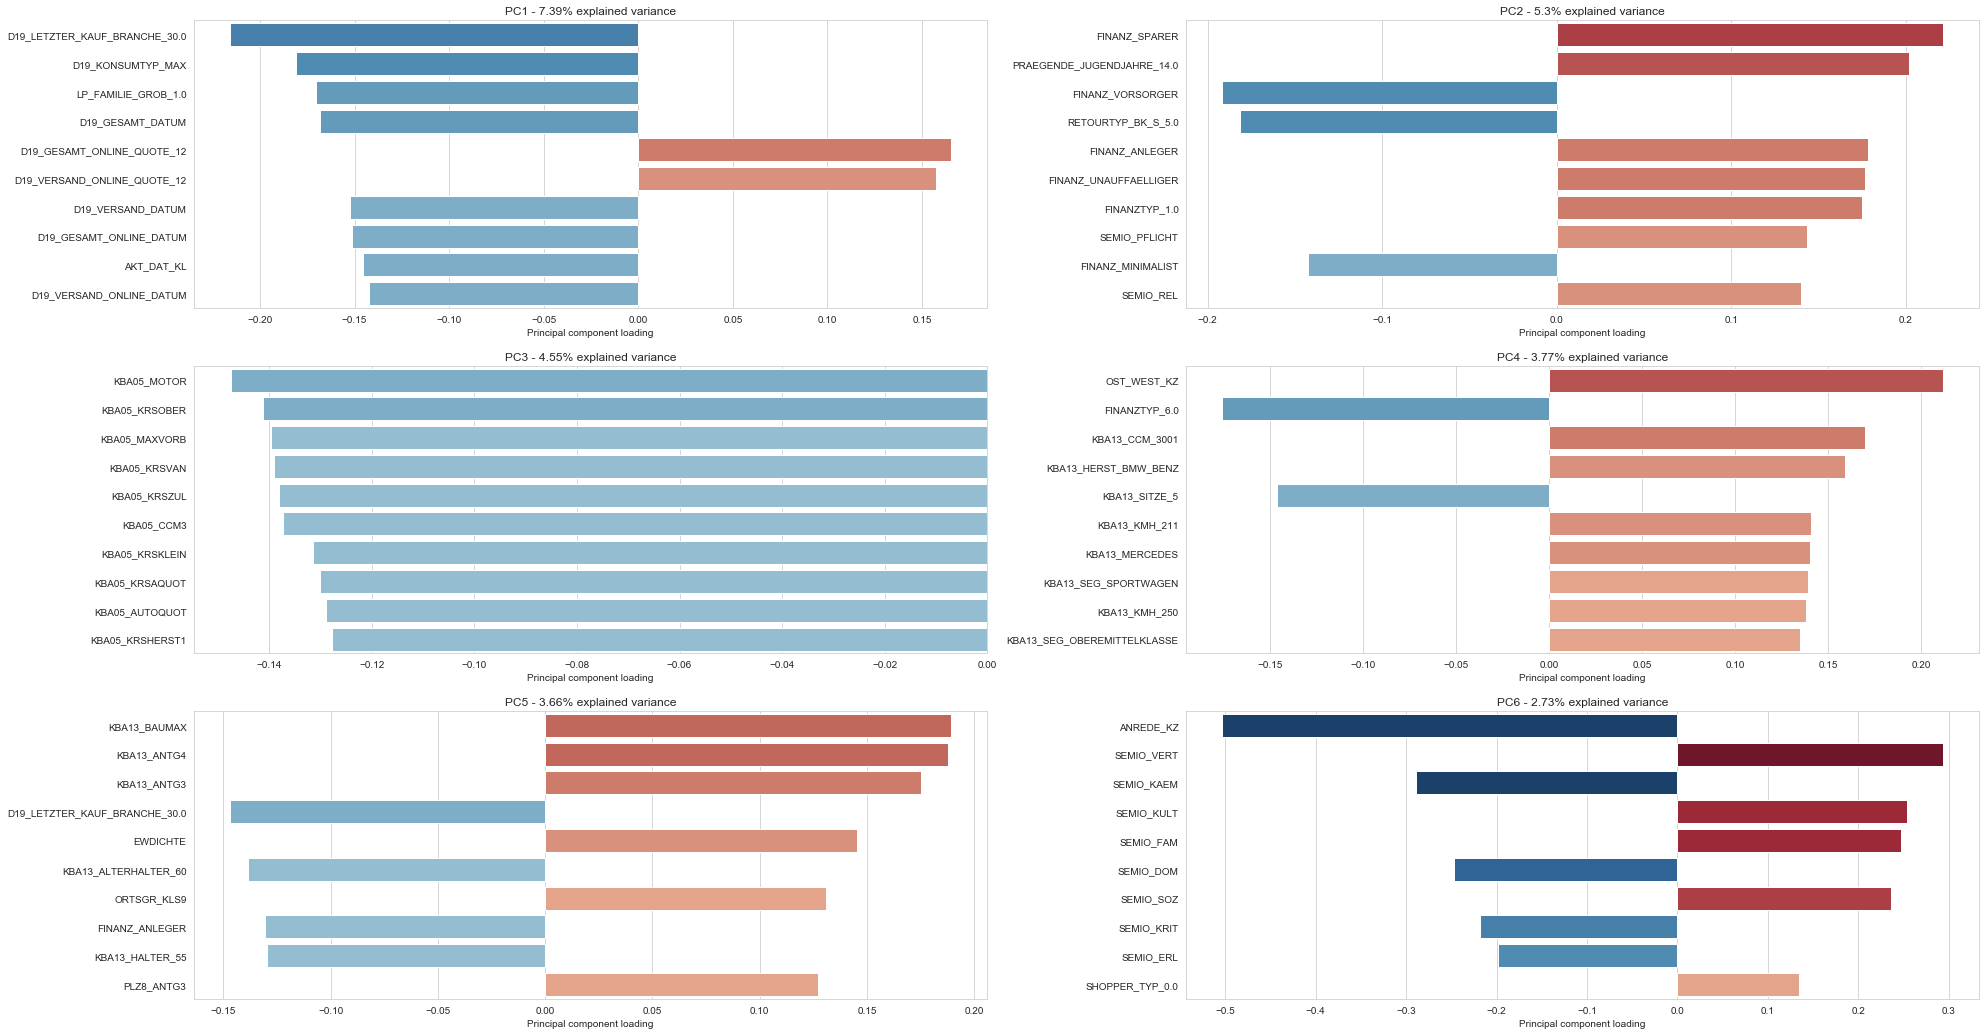

In [15]:
plt.figure(figsize=(32, 18))
plt.subplots_adjust(wspace=0.25) # adjusting the horizontal space between plots

# The variables cmap and norm help us color the bars based on the PCA weight value
cmap = matplotlib.colors.ListedColormap(sns.color_palette('RdBu_r', n_colors=30))
norm = plt.Normalize(-0.3, 0.3)

# Create a 3 x 2 grid for the top 6 principal components
for i in range(1, 7, 1):
        plt.subplot(3, 2, i)
        sns.barplot(x=globals()['pc'+str(i)].values,
                    y=globals()['pc'+str(i)].index,
                    palette=cmap(norm(globals()['pc'+str(i)].values)))
        plt.title('PC{} - {}% explained variance'
                  .format(i, np.round(pca.explained_variance_ratio_[i-1]*100, decimals=2)))
        plt.xlabel('Principal component loading')

plt.show()

### PC Interpretation

**Principal Component 1**

In [167]:
pd.DataFrame(pc1).T

,D19_LETZTER_KAUF_BRANCHE_30.0,D19_KONSUMTYP_MAX,LP_FAMILIE_GROB_1.0,D19_GESAMT_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_DATUM,D19_GESAMT_ONLINE_DATUM,AKT_DAT_KL,D19_VERSAND_ONLINE_DATUM
0,-0.216061,-0.181144,-0.170317,-0.168083,0.16541,0.157223,-0.152205,-0.15132,-0.145614,-0.142351


**Principal Component 2**

In [31]:
pd.DataFrame(pc2).T

,FINANZ_SPARER,PRAEGENDE_JUGENDJAHRE_14.0,FINANZ_VORSORGER,RETOURTYP_BK_S_5.0,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZTYP_1.0,SEMIO_PFLICHT,FINANZ_MINIMALIST,SEMIO_REL
0,0.221457,0.201813,-0.191897,-0.181141,0.178553,0.176546,0.174952,0.143248,-0.142367,0.140305


**Principal Component 3**

In [39]:
pd.DataFrame(pc4).index

Index(['OST_WEST_KZ', 'FINANZTYP_6.0', 'KBA13_CCM_3001',
       'KBA13_HERST_BMW_BENZ', 'KBA13_SITZE_5', 'KBA13_KMH_211',
       'KBA13_MERCEDES', 'KBA13_SEG_SPORTWAGEN', 'KBA13_KMH_250',
       'KBA13_SEG_OBEREMITTELKLASSE'],
      dtype='object')

**Principal Component 4**

In [33]:
pd.DataFrame(pc4).T

,OST_WEST_KZ,FINANZTYP_6.0,KBA13_CCM_3001,KBA13_HERST_BMW_BENZ,KBA13_SITZE_5,KBA13_KMH_211,KBA13_MERCEDES,KBA13_SEG_SPORTWAGEN,KBA13_KMH_250,KBA13_SEG_OBEREMITTELKLASSE
0,0.211751,-0.175999,0.170017,0.158776,-0.145994,0.140551,0.140321,0.138941,0.138077,0.134768


**Principal Component 5**

In [35]:
pd.DataFrame(pc5).T

,KBA13_BAUMAX,KBA13_ANTG4,KBA13_ANTG3,D19_LETZTER_KAUF_BRANCHE_30.0,EWDICHTE,KBA13_ALTERHALTER_60,ORTSGR_KLS9,FINANZ_ANLEGER,KBA13_HALTER_55,PLZ8_ANTG3
0,0.189257,0.187964,0.175212,-0.147118,0.14541,-0.138358,0.131042,-0.130627,-0.129666,0.127092


**Principal Component 6**

In [34]:
pd.DataFrame(pc6).T

,ANREDE_KZ,SEMIO_VERT,SEMIO_KAEM,SEMIO_KULT,SEMIO_FAM,SEMIO_DOM,SEMIO_SOZ,SEMIO_KRIT,SEMIO_ERL,SHOPPER_TYP_0.0
0,-0.503842,0.293599,-0.288606,0.253845,0.246907,-0.246882,0.236129,-0.218587,-0.198619,0.134657


## 2.4. Transforming the datasets

In [17]:
population_reduced = pca.transform(population)
customers_reduced = pca.transform(customers.loc[:, population.columns])

In [18]:
print(population_reduced.shape)
print(customers_reduced.shape)

(785414, 127)
(140358, 127)


# 3. Clustering

## 3.1. Benchmark: quantile matching on the first 2 components

In [60]:
mean_pc1 = population_reduced[:, 0].mean()
mean_pc2 = population_reduced[:, 1].mean()

In [76]:
benchmark_data = pd.DataFrame(population_reduced[:, 0:2])
benchmark_data = benchmark_data.assign(cluster=0)
benchmark_data.loc[(benchmark_data[0]<=mean_pc1) & (benchmark_data[1]<=mean_pc2), 'cluster'] = 1 
benchmark_data.loc[(benchmark_data[0]<=mean_pc1) & (benchmark_data[1]>mean_pc2), 'cluster'] = 2
benchmark_data.loc[(benchmark_data[0]>mean_pc1) & (benchmark_data[1]<=mean_pc2), 'cluster'] = 3
benchmark_data.loc[(benchmark_data[0]>mean_pc1) & (benchmark_data[1]>mean_pc2), 'cluster'] = 4

In [79]:
print(calinski_harabasz_score(benchmark_data.iloc[:, 0:2], benchmark_data.iloc[:, 2]))

640370.7483523645


In [80]:
print(davies_bouldin_score(benchmark_data.iloc[:, 0:2], benchmark_data.iloc[:, 2]))

0.8973404903621766


## 3.2. k-Means: Optimal number of clusters

This will be determined based on the within-cluster sum of squared errors returned by the score() method of the KMeans class in scikit-learn. In order to speed up the fit method of the KMeans class, we will use MiniBatchKMeans just for the part of determining the number of clusters.

In [19]:
%%time
score_list = []
for i in range(2, 21, 1):
    score_list.append(MiniBatchKMeans(n_clusters=i, random_state=77, verbose=0,
                                      compute_labels=False).fit(population_reduced).score(population_reduced))

Wall time: 1min 28s


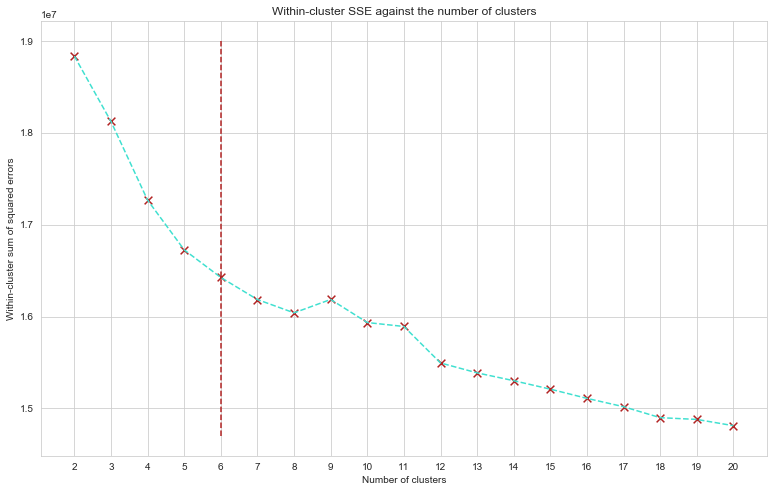

In [27]:
plt.figure(figsize=(13, 8))
plt.scatter(np.arange(2, 21, 1), np.abs(score_list), color='firebrick', marker='x', s=60)
plt.plot(np.arange(2, 21, 1), np.abs(score_list), linestyle='dashed', color='turquoise')
plt.vlines(x=6, ymin=1.47e7, ymax=1.9e7, color='firebrick', linestyles='--', zorder=2)
plt.xticks(np.arange(2, 21, 1))
plt.xlabel('Number of clusters')
plt.title('Within-cluster SSE against the number of clusters')
plt.ylabel('Within-cluster sum of squared errors')
plt.show()

While there are multiple plateau values, let us consider 6 clusters, in order to balance both the dimensionality and the quality of the clusters.

In [20]:
nclust = 6

## 3.3. Population k-Means

In [21]:
%%time
kmeans = KMeans(n_clusters=nclust, n_init=10, max_iter=300, random_state=777, n_jobs=-1, verbose=0)
kmeans.fit(population_reduced)
pickle.dump(kmeans, open('./data/PopulationKMeans.pkl', 'wb'))

Wall time: 1min 50s


In [22]:
population_clusters = kmeans.predict(population_reduced)

### Metrics

**The silhouette coefficient** <br>
"The Silhouette Coefficient is a measure of how well samples are clustered with samples that are similar to themselves." (source: [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)).

In [228]:
%%time
silhouette = silhouette_score(population_reduced, population_clusters)
pickle.dump(silhouette, open('./data/PopulationSilhouetteScore.pkl', 'wb'))
print(silhouette)

0.05161841423115561
Wall time: 2h 31min 6s


Values close to 0 indicate overlapping clusters. High variance in data -> overlapping clusters. Common problem in census-type data ananalyses.

**The Calinski-Harabasz score** <br>
"The [Calinski-Harabasz] score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion" (source: [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)). This shows how compact and well separated the clusters are.

In [230]:
calinski_harabasz = calinski_harabasz_score(population_reduced, population_clusters)
print(calinski_harabasz)

35837.2422091571


**The Davies-Bouldin score** <br>

In [231]:
davies_bouldin = davies_bouldin_score(population_reduced, population_clusters)
print(davies_bouldin)

3.4422737696323957


# 4 Customer insights

## 4.1. Assigning customers to population clusters

In [23]:
customers_clusters = kmeans.predict(customers_reduced)

## 4.2. Customers vs. Population: cluster distribution

First of all let's see how our two cohorts are distributed along the 6 clusters.

In [24]:
cluster_plot_df = pd.DataFrame(columns=['cluster', 'cohort', 'cohort_percentage'])
cluster_plot_df.loc[:, 'cluster'] = np.sort(np.concatenate((pd.Series(customers_clusters).unique(),
                                                            pd.Series(population_clusters).unique())))

cluster_plot_df.loc[:, 'cohort'] = ['population', 'customers'] * nclust

population_proportions = np.array(pd.Series(population_clusters).value_counts().sort_index()/population_clusters.shape[0])
customer_proportions = np.array(pd.Series(customers_clusters).value_counts().sort_index()/customers_clusters.shape[0])
cluster_plot_df.loc[cluster_plot_df.cohort == 'population', 'cohort_percentage'] = population_proportions.copy()
cluster_plot_df.loc[cluster_plot_df.cohort == 'customers', 'cohort_percentage'] = customer_proportions.copy()

Additionally, let's see the difference in cohort proportions within each cluster. This metric tells us in which clusters we have the most, as well as the least customers (proportionally). This is an indication of market penetration

In [25]:
proportion_difference = cluster_plot_df.loc[cluster_plot_df.cohort=='population', 'cohort_percentage'].sort_index().values - \
                        cluster_plot_df.loc[cluster_plot_df.cohort=='customers', 'cohort_percentage'].sort_index().values

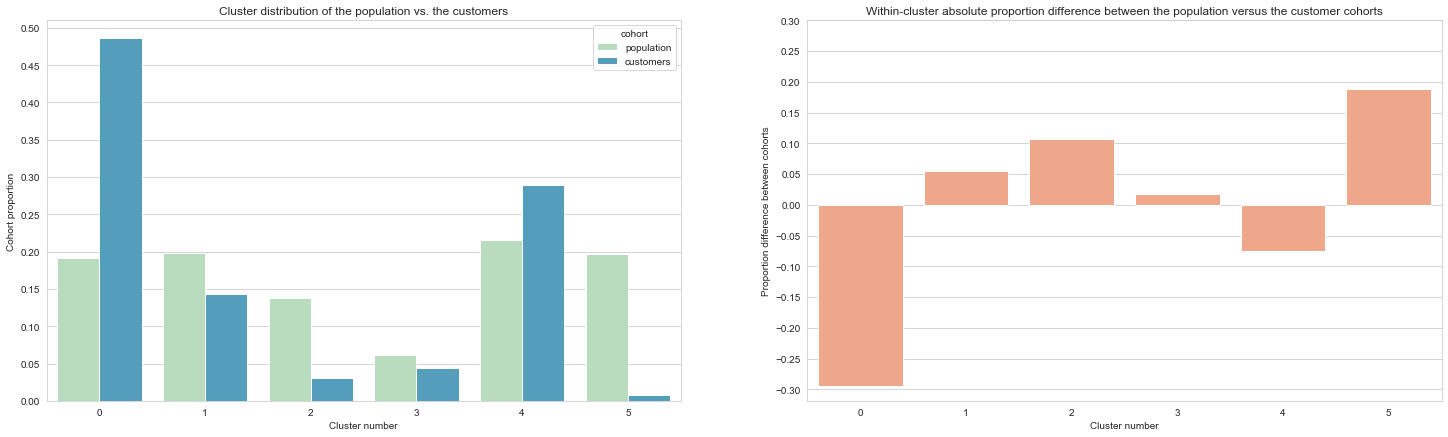

In [26]:
plt.figure(figsize=(25, 7))

plt.subplot(121)
sns.barplot(x=cluster_plot_df.cluster, y=cluster_plot_df.cohort_percentage, hue=cluster_plot_df.cohort, palette='GnBu')
plt.title('Cluster distribution of the population vs. the customers')
plt.xlabel('Cluster number')
plt.ylabel('Cohort proportion')
plt.yticks(np.arange(0, 0.55, 0.05))

plt.subplot(122)
sns.barplot(x=cluster_plot_df.cluster.unique(),
            y=proportion_difference,
            color='lightsalmon')
plt.title('Within-cluster absolute proportion difference between the population versus the customer cohorts')
plt.xlabel('Cluster number')
plt.ylabel('Proportion difference between cohorts')
plt.yticks(np.arange(-0.3, 0.31, 0.05))

plt.show()

## Centroid analysis

The principal components with the highest values for the most popular, second most popular, and least popular cluster for the customers.

In [54]:
# Most popular cluster
np.abs(kmeans.cluster_centers_[0]).argsort()[-3:][::-1]

array([0, 4, 2], dtype=int64)

In [55]:
# Second most popular cluster
np.abs(kmeans.cluster_centers_[4]).argsort()[-3:][::-1]

array([1, 4, 3], dtype=int64)

In [57]:
# Least popular cluster
np.abs(kmeans.cluster_centers_[5]).argsort()[-3:][::-1]

array([0, 1, 2], dtype=int64)